In [1]:
import os
import numpy as np
import cv2
import rasterio
from rasterio import features
from rasterio.transform import rowcol
import geopandas as gpd
from shapely.geometry import shape
from shapely.affinity import translate
import math
import matplotlib.pyplot as plt

# --- CONFIGURATION (LAS VEGAS AOI 2) ---
CONFIG = {
    # Physics Constants (Oct 22, 2015 - SpaceNet Acquisition)
    "SUN_AZIMUTH": 170.5,       # Sun is South-South-East
    "SUN_ELEVATION": 43.2,      # Sun Height
    "PIXEL_RES": 0.3,           # 30cm per pixel (WorldView-3)
    "FLOOR_HEIGHT": 3.2,        # Avg height of a floor (meters)
    
    # Tuning Parameters
    "MIN_SHADOW_PX": 10,        # Minimum shadow length to count (ignore noise)
    "SEARCH_DIST_M": 20.0,      # Look for shadows up to 20m away
    
    # Directories (Update these to your actual paths)
    "IMG_DIR": "PS-RGB",
    "LABEL_DIR": "geojson_buildings"
}

print("✅ Configuration Loaded.")

✅ Configuration Loaded.


In [2]:
def tsai_shadow_detection(rgb_image):
    """
    Implements Tsai (2006) Spectral Ratio Algorithm.
    Formula: Ratio = (Hue + 1) / (Intensity + 1)
    """
    # 1. Convert to HLS (Hue, Lightness, Saturation)
    # OpenCV uses H:0-179, L:0-255, S:0-255
    hls = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HLS)
    H, L, S = cv2.split(hls)
    
    # 2. Normalize components to 0-1 range
    H_norm = H / 179.0
    I_norm = L / 255.0 
    
    # 3. Calculate Ratio
    # Add epsilon (0.05) to avoid division by zero
    ratio = (H_norm + 1) / (I_norm + 0.05)
    
    # 4. Normalize Ratio back to 0-255 for Thresholding
    ratio_norm = cv2.normalize(ratio, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # 5. Otsu's Thresholding (Automatic cutoff)
    thresh_val, shadow_mask = cv2.threshold(ratio_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 6. Cleanup (Morphological Opening to remove salt noise)
    kernel = np.ones((3,3), np.uint8)
    clean_mask = cv2.morphologyEx(shadow_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    
    return clean_mask

print("✅ Shadow Detector Ready.")

✅ Shadow Detector Ready.


In [3]:
def measure_shadow_length(shadow_mask, sun_azimuth):
    """
    Rotates the shadow mask so the shadow points 'Right' (0 degrees),
    then scans every row to find the maximum continuous shadow length.
    """
    rows, cols = shadow_mask.shape
    
    # 1. Calculate Rotation Angle
    # Shadow falls OPPOSITE to Sun.
    # We want to rotate the shadow to align with the X-Axis (0 deg).
    shadow_direction = (sun_azimuth + 180) % 360
    rotation_needed = -shadow_direction
    
    # 2. Rotate Image
    center = (cols // 2, rows // 2)
    M = cv2.getRotationMatrix2D(center, rotation_needed, 1.0)
    rotated = cv2.warpAffine(shadow_mask, M, (cols, rows))
    
    max_len_px = 0
    
    # 3. Scan Rows
    # Optimization: Scan every 2nd row to speed up
    for y in range(0, rows, 2):
        row_pixels = rotated[y, :]
        if np.sum(row_pixels) == 0: continue # Skip empty rows
        
        # Find continuous runs of pixels
        contours, _ = cv2.findContours(row_pixels.reshape(1, -1), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for cnt in contours:
            # For a 1-pixel high line, Area ~ Length. 
            # ArcLength/2 is safer for irregular shapes.
            length = cv2.arcLength(cnt, True) / 2
            if length > max_len_px:
                max_len_px = length
                
    return max_len_px

print("✅ Measurement Engine Ready.")

✅ Measurement Engine Ready.


In [10]:
def normalize_to_8bit(img_16bit):
    """
    Converts 16-bit satellite image to 8-bit.
    FIX: Forces memory to be contiguous to prevent OpenCV crashes.
    """
    # 1. Force contiguous memory layout (Fixes the "Layout incompatible" error)
    img_16bit = np.ascontiguousarray(img_16bit)
    
    # 2. Normalize (Let OpenCV allocate the output array automatically)
    # Passing 'None' as destination prevents shape mismatch errors
    img_8bit = cv2.normalize(img_16bit, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    return img_8bit

def process_single_tile(tif_path, geojson_path):
    print(f"\nProcessing: {os.path.basename(tif_path)}")
    
    # 1. Read Image & Metadata
    with rasterio.open(tif_path) as src:
        # Read RGB bands (1, 2, 3)
        img = src.read([1, 2, 3]) 
        img = np.moveaxis(img, 0, -1) # Convert to H,W,C
        
        # --- FIX: CONVERT 16-BIT TO 8-BIT ---
        # Handle SpaceNet's uint16 data
        if img.dtype == 'uint16':
            img = normalize_to_8bit(img)
            
        transform = src.transform
        crs = src.crs
        
        # 2. Read GeoJSON
        try:
            gdf = gpd.read_file(geojson_path)
        except Exception as e:
            print(f"  ❌ Error reading GeoJSON: {e}")
            return

        # 3. Coordinate Conversion
        if gdf.crs != crs:
            gdf = gdf.to_crs(crs)
            
        print(f"  Found {len(gdf)} buildings.")
        
        results = []
        
        # 4. Iterate Buildings
        for idx, row in gdf.iterrows():
            # A. Create Building Mask
            geom = [row.geometry]
            building_mask = features.rasterize(
                geom,
                out_shape=img.shape[:2],
                transform=transform,
                fill=0,
                default_value=255,
                dtype=np.uint8
            )
            
            # B. Create Search Zone
            shadow_azimuth_rad = math.radians((CONFIG["SUN_AZIMUTH"] + 180) % 360)
            dist_px = CONFIG["SEARCH_DIST_M"] / CONFIG["PIXEL_RES"]
            
            dx = int(dist_px * math.sin(shadow_azimuth_rad))
            dy = int(dist_px * math.cos(shadow_azimuth_rad)) * -1
            
            M_shift = np.float32([[1, 0, dx], [0, 1, dy]])
            shifted_mask = cv2.warpAffine(building_mask, M_shift, (img.shape[1], img.shape[0]))
            search_zone = cv2.subtract(shifted_mask, building_mask)
            
            # C. Detect Shadows (Tsai)
            full_shadow_mask = tsai_shadow_detection(img)
            
            # D. Masking
            valid_shadow = cv2.bitwise_and(full_shadow_mask, full_shadow_mask, mask=search_zone)
            
            # E. Measure
            px_length = measure_shadow_length(valid_shadow, CONFIG["SUN_AZIMUTH"])
            
            if px_length < CONFIG["MIN_SHADOW_PX"]:
                continue
                
            # F. Physics Calculation
            shadow_m = px_length * CONFIG["PIXEL_RES"]
            tan_theta = math.tan(math.radians(CONFIG["SUN_ELEVATION"]))
            height_m = shadow_m * tan_theta
            floors = round(height_m / CONFIG["FLOOR_HEIGHT"])
            
            results.append({
                "id": idx,
                "shadow_m": round(shadow_m, 2),
                "height_m": round(height_m, 2),
                "floors": int(floors)
            })
            
        return results

print("✅ Main Engine Fixed (Contiguous Memory Added).")

✅ Main Engine Fixed (Contiguous Memory Added).


In [11]:
import glob

# 1. Find Files
tif_files = sorted(glob.glob(os.path.join(CONFIG["IMG_DIR"], "*.tif")))
geojson_files = sorted(glob.glob(os.path.join(CONFIG["LABEL_DIR"], "*.geojson")))

print(f"Found {len(tif_files)} Images and {len(geojson_files)} GeoJSONs.")

# 2. Run on the first 3 files as a demo
for i in range(min(3, len(tif_files))):
    t_path = tif_files[i]
    
    # Find matching GeoJSON (assumes naming convention matches)
    # Extract ID (e.g., 'img10') to match files
    base_name = os.path.basename(t_path).replace(".tif", "")
    # Try to find corresponding geojson
    g_path = None
    for g in geojson_files:
        if base_name.split("_")[-1] in g: # Match 'img10' part
            g_path = g
            break
            
    if g_path:
        data = process_single_tile(t_path, g_path)
        
        # Print Top 5 Tallest Buildings Found
        if data:
            sorted_data = sorted(data, key=lambda x: x['floors'], reverse=True)
            print("  🏢 Top Detections:")
            for b in sorted_data[:5]:
                print(f"    - ID {b['id']}: {b['floors']} Floors ({b['height_m']}m)")
        else:
            print("  ⚠️ No significant shadows found.")
    else:
        print(f"  ❌ No matching GeoJSON found for {base_name}")

Found 10 Images and 10 GeoJSONs.

Processing: SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1.tif
  Found 16 buildings.
  🏢 Top Detections:
    - ID 0: 1 Floors (3.1m)

Processing: SN2_buildings_train_AOI_2_Vegas_PS-RGB_img10.tif
  Found 28 buildings.
  🏢 Top Detections:
    - ID 5: 1 Floors (3.1m)
    - ID 19: 1 Floors (3.1m)
    - ID 20: 1 Floors (3.38m)
    - ID 21: 1 Floors (3.1m)
    - ID 22: 1 Floors (3.1m)

Processing: SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1002.tif
  Found 0 buildings.
  ⚠️ No significant shadows found.


In [13]:
def normalize_to_8bit_robust(img_16bit):
    """
    Robustly converts 16-bit to 8-bit using Percentile Clipping (2%-98%).
    This ignores 'hot pixels' that make the rest of the image look black.
    """
    # Force contiguous memory (Fixes OpenCV errors)
    img = np.ascontiguousarray(img_16bit)
    
    # Calculate 2nd and 98th percentile limits
    # This ignores the darkest 2% and brightest 2% of pixels
    # (e.g., sun glint on cars or black borders)
    low_val = np.percentile(img, 2)
    high_val = np.percentile(img, 98)
    
    # Clip data to this range
    img_clipped = np.clip(img, low_val, high_val)
    
    # Now scale to 0-255
    img_8bit = cv2.normalize(img_clipped, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    return img_8bit

🔍 Debugging: PS-RGB\SN2_buildings_train_AOI_2_Vegas_PS-RGB_img10.tif

[Raw 16-bit Stats]
  Min: 0, Max: 1805, Mean: 386.15

[8-bit Robust Stats]
  Min: 0, Max: 255, Mean: 94.47

[HLS Stats]
  Hue Mean: 56.63 (0-179)
  Lightness Mean: 94.60 (0-255)

[Spectral Ratio Stats]
  Ratio Min: 0.9524, Max: 20.0000


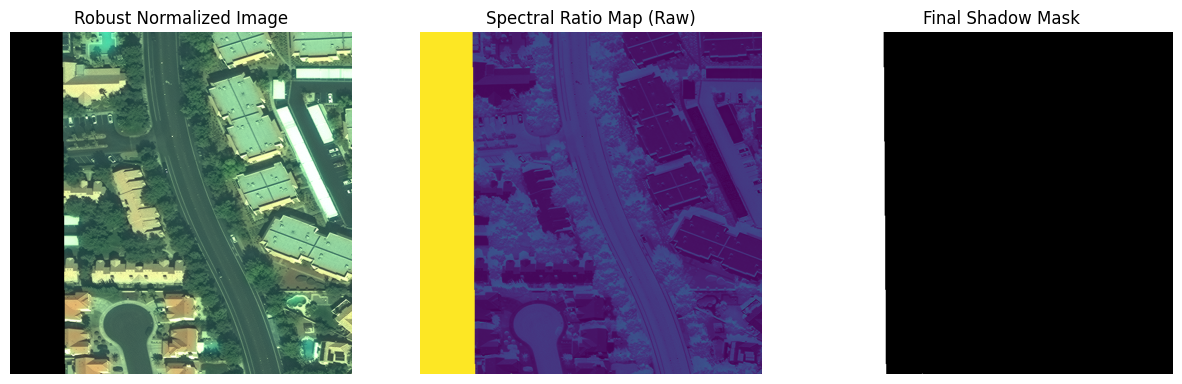

In [14]:
# --- DEBUGGING CELL ---
import rasterio
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Pick the file that gave you trouble
target_id = "PS-RGB_img10" # Ensure this file exists
t_path = os.path.join(CONFIG["IMG_DIR"], f"SN2_buildings_train_AOI_2_Vegas_{target_id}.tif")

print(f"🔍 Debugging: {t_path}")

with rasterio.open(t_path) as src:
    # 1. Read Raw 16-bit Data
    img_16 = src.read([1, 2, 3])
    img_16 = np.moveaxis(img_16, 0, -1)
    
    print(f"\n[Raw 16-bit Stats]")
    print(f"  Min: {img_16.min()}, Max: {img_16.max()}, Mean: {img_16.mean():.2f}")
    
    # 2. Apply Robust Normalization
    img_8 = normalize_to_8bit_robust(img_16)
    
    print(f"\n[8-bit Robust Stats]")
    print(f"  Min: {img_8.min()}, Max: {img_8.max()}, Mean: {img_8.mean():.2f}")
    
    # 3. Check HLS Conversion
    hls = cv2.cvtColor(img_8, cv2.COLOR_RGB2HLS)
    H, L, S = cv2.split(hls)
    
    print(f"\n[HLS Stats]")
    print(f"  Hue Mean: {H.mean():.2f} (0-179)")
    print(f"  Lightness Mean: {L.mean():.2f} (0-255)")

    # 4. Run Tsai Manually to check the Ratio Map
    H_norm = H / 179.0
    I_norm = L / 255.0
    ratio = (H_norm + 1) / (I_norm + 0.05)
    
    print(f"\n[Spectral Ratio Stats]")
    print(f"  Ratio Min: {ratio.min():.4f}, Max: {ratio.max():.4f}")
    
    # 5. Visualize
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img_8)
    plt.title("Robust Normalized Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(ratio, cmap='viridis')
    plt.title("Spectral Ratio Map (Raw)")
    plt.axis('off')
    
    # Apply Otsu
    ratio_norm = cv2.normalize(ratio, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    _, shadow_mask = cv2.threshold(ratio_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    plt.subplot(1, 3, 3)
    plt.imshow(shadow_mask, cmap='gray')
    plt.title("Final Shadow Mask")
    plt.axis('off')
    
    plt.show()

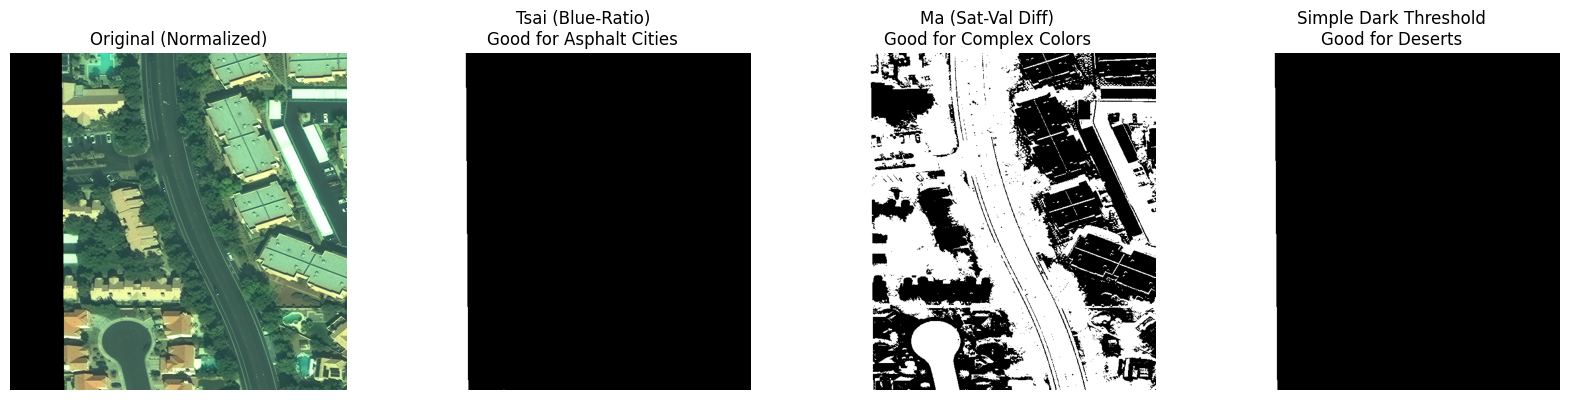

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import rasterio

# --- CONFIG FOR LAS VEGAS ---
target_id = "PS-RGB_img10" # The file we know has buildings
path = os.path.join(CONFIG["IMG_DIR"], f"SN2_buildings_train_AOI_2_Vegas_{target_id}.tif")

def robust_normalize(img):
    # Clips outliers so the image isn't pitch black
    img = np.ascontiguousarray(img)
    low = np.percentile(img, 2)
    high = np.percentile(img, 98)
    clipped = np.clip(img, low, high)
    return cv2.normalize(clipped, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# 1. Load Image
with rasterio.open(path) as src:
    raw = src.read([1, 2, 3])
    raw = np.moveaxis(raw, 0, -1)
    img_rgb = robust_normalize(raw)

# --- ALGORITHM 1: TSAI (Spectral Ratio) ---
# Formula: (Hue + 1) / (Intensity + 1)
hls = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
H = hls[:,:,0].astype(float) / 179.0
L = hls[:,:,1].astype(float) / 255.0
ratio_tsai = (H + 1) / (L + 0.05)
ratio_tsai_norm = cv2.normalize(ratio_tsai, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
_, mask_tsai = cv2.threshold(ratio_tsai_norm, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# --- ALGORITHM 2: MA (NSVDI Index) ---
# Formula: (Saturation - Value) / (Saturation + Value)
hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
S = hsv[:,:,1].astype(float)
V = hsv[:,:,2].astype(float)
# Add epsilon to avoid divide by zero
nsvdi = (S - V) / (S + V + 0.001)
nsvdi_norm = cv2.normalize(nsvdi, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
_, mask_ma = cv2.threshold(nsvdi_norm, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# --- ALGORITHM 3: SIMPLE LUMINANCE (The "Darkness" Test) ---
# Just find the darkest 15% of pixels (Classic approach)
gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
thresh_val = np.percentile(gray, 15) # Assume shadows are in bottom 15% brightness
_, mask_simple = cv2.threshold(gray, thresh_val, 255, cv2.THRESH_BINARY_INV)

# --- VISUALIZE THE WINNER ---
plt.figure(figsize=(20, 6))

plt.subplot(1, 4, 1)
plt.imshow(img_rgb)
plt.title("Original (Normalized)")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(mask_tsai, cmap='gray')
plt.title("Tsai (Blue-Ratio)\nGood for Asphalt Cities")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(mask_ma, cmap='gray')
plt.title("Ma (Sat-Val Diff)\nGood for Complex Colors")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(mask_simple, cmap='gray')
plt.title("Simple Dark Threshold\nGood for Deserts")
plt.axis('off')

plt.show()